# Multinomial regression

In this notebook we perform multinomial / softmax resression

### Import functions

In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func_method
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model
from Code.plot import *

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/a/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the data

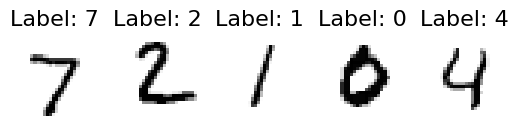

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)
# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

### Single run

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


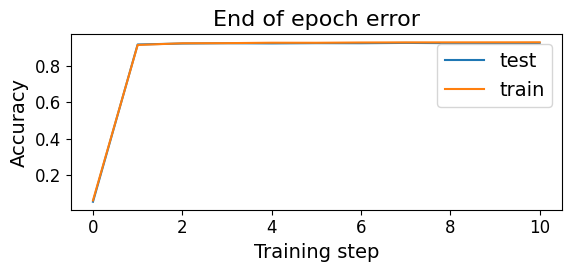

test:  0.9240999817848206
train:  0.9275500178337097
CE test:  0.9241
CE train:  0.92755


In [3]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, epochs=300, batch_size=32, 
               plot_or_not=False, result_filepath=None, store_params=False, 
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               intermediate_epochs=None):
    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X_train.shape[1], output_shape=y_train.shape[1])
    model = softmax_model

    # Create gradient from loss function. Also get the accuracy function. lam=0 gives MSE
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0](model))
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel=test_func_and_name[1])

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                  "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                  "lr"                : lr, 
                                  "lam"               : lam,
                                  "epochs"            : ie,
                                  "batch_size"        : batch_size,
                                  "train_num"         : y_train.shape[0],
                                   "test_num"          : y_test.shape[0]}

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "lr"                : lr, 
                          "lam"               : lam,
                          "epochs"            : epochs,
                          "batch_size"        : batch_size,
                          "train_num"         : y_train.shape[0],
                          "test_num"          : y_test.shape[0]}
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}
        append_run_to_file(result_filepath, _dict_to_store)

    return result

## A demonstration
epochs = 10
batch_size = 128 #8192 #4096 2048 # 128 # 1024
lr = 0.005 # 0.01
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=0.0001, epochs=epochs, batch_size=batch_size,
                    plot_or_not=True, test_func_and_name=(accuracy_func_method, "Accuracy"), 
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

### Learning rate, batch size and epoch number

In [4]:
def run_experiment():
    batch_sizes           = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    learning_rates        = [0.1, 0.05, 0.02, 0.01, 0.005, 0.001]
    regularisation_params = [0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

    # We do one run with max epoch number, storing the intermediate as their own runs
    epoch_numbers = [2, 5, 8, 10, 15, 20, 35, 50]

    # Path to result
    result_filepath = "Results/multinomial_28.json"

    # Perform the #b*#l*#e experiments
    for r in regularisation_params:
        for l in learning_rates:
            for b in batch_sizes:
                print(f"Batch Size: {b}, Learning Rate: {l}, Regularisation: {r}")

                result = single_run(X_train, X_test, y_train, y_test, 
                                    lr=l, lam=r, epochs=epoch_numbers[-1], batch_size=b,
                                    plot_or_not=False, result_filepath=result_filepath, intermediate_epochs=epoch_numbers[0:-1])
                
# run_experiment()

Batch Size: 32, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:07<00:00,  7.14it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:06<00:00,  7.16it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 0


100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:09<00:00,  5.47it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.70it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.41it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:06<00:00,  8.31it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:09<00:00,  5.51it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 50/50 [00:09<00:00,  5.43it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Batch Size: 32, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Batch Size: 64, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Batch Size: 128, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


Batch Size: 256, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Batch Size: 512, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


Batch Size: 1024, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:05<00:00,  9.10it/s]


Batch Size: 2048, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Batch Size: 4096, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Batch Size: 8192, Learning Rate: 0.1, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


Batch Size: 32, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


Batch Size: 64, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Batch Size: 128, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Batch Size: 256, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Batch Size: 512, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Batch Size: 1024, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Batch Size: 2048, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Batch Size: 4096, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Batch Size: 8192, Learning Rate: 0.05, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Batch Size: 64, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Batch Size: 128, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


Batch Size: 256, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Batch Size: 512, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


Batch Size: 1024, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:05<00:00,  9.11it/s]


Batch Size: 2048, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Batch Size: 4096, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Batch Size: 8192, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Batch Size: 128, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Batch Size: 256, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Batch Size: 512, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Batch Size: 1024, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


Batch Size: 2048, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


Batch Size: 4096, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Batch Size: 8192, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Batch Size: 256, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Batch Size: 512, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Batch Size: 1024, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


Batch Size: 2048, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Batch Size: 4096, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


Batch Size: 8192, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Batch Size: 128, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


Batch Size: 256, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Batch Size: 512, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Batch Size: 1024, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


Batch Size: 2048, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Batch Size: 4096, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


Batch Size: 8192, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


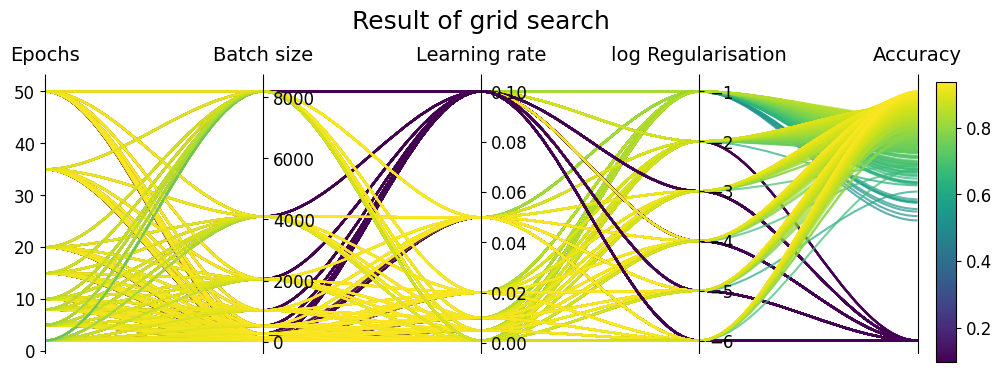

In [18]:
run_list = load_run_from_file("Results/multinomial_28.json")


data = {
    "Epochs": [],
    "Batch size": [],
    "Learning rate": [],
    "log Regularisation": [],
    "Accuracy": [],
}

for run in run_list:

    ## TODO HANDLE
    if run["test_accuracy"] >= 0:#0.92:

        if run["lam"] > 0:

            data["Epochs"].append(run["epochs"])
            data["Batch size"].append(run["batch_size"])
            data["Learning rate"].append(run["lr"])
            data["log Regularisation"].append(np.log10(run["lam"]))
            data["Accuracy"].append(run["train_accuracy"])

plot_grid_search_result(data)


### Final model evaluation

In [ ]:
l = 0.01
e = 100
b = 64

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=l, lam=0.0001, epochs=e, batch_size=b,
                    plot_or_not=False, result_filepath=result_filepath)

model = result["model"]
beta = result["beta_final"]

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


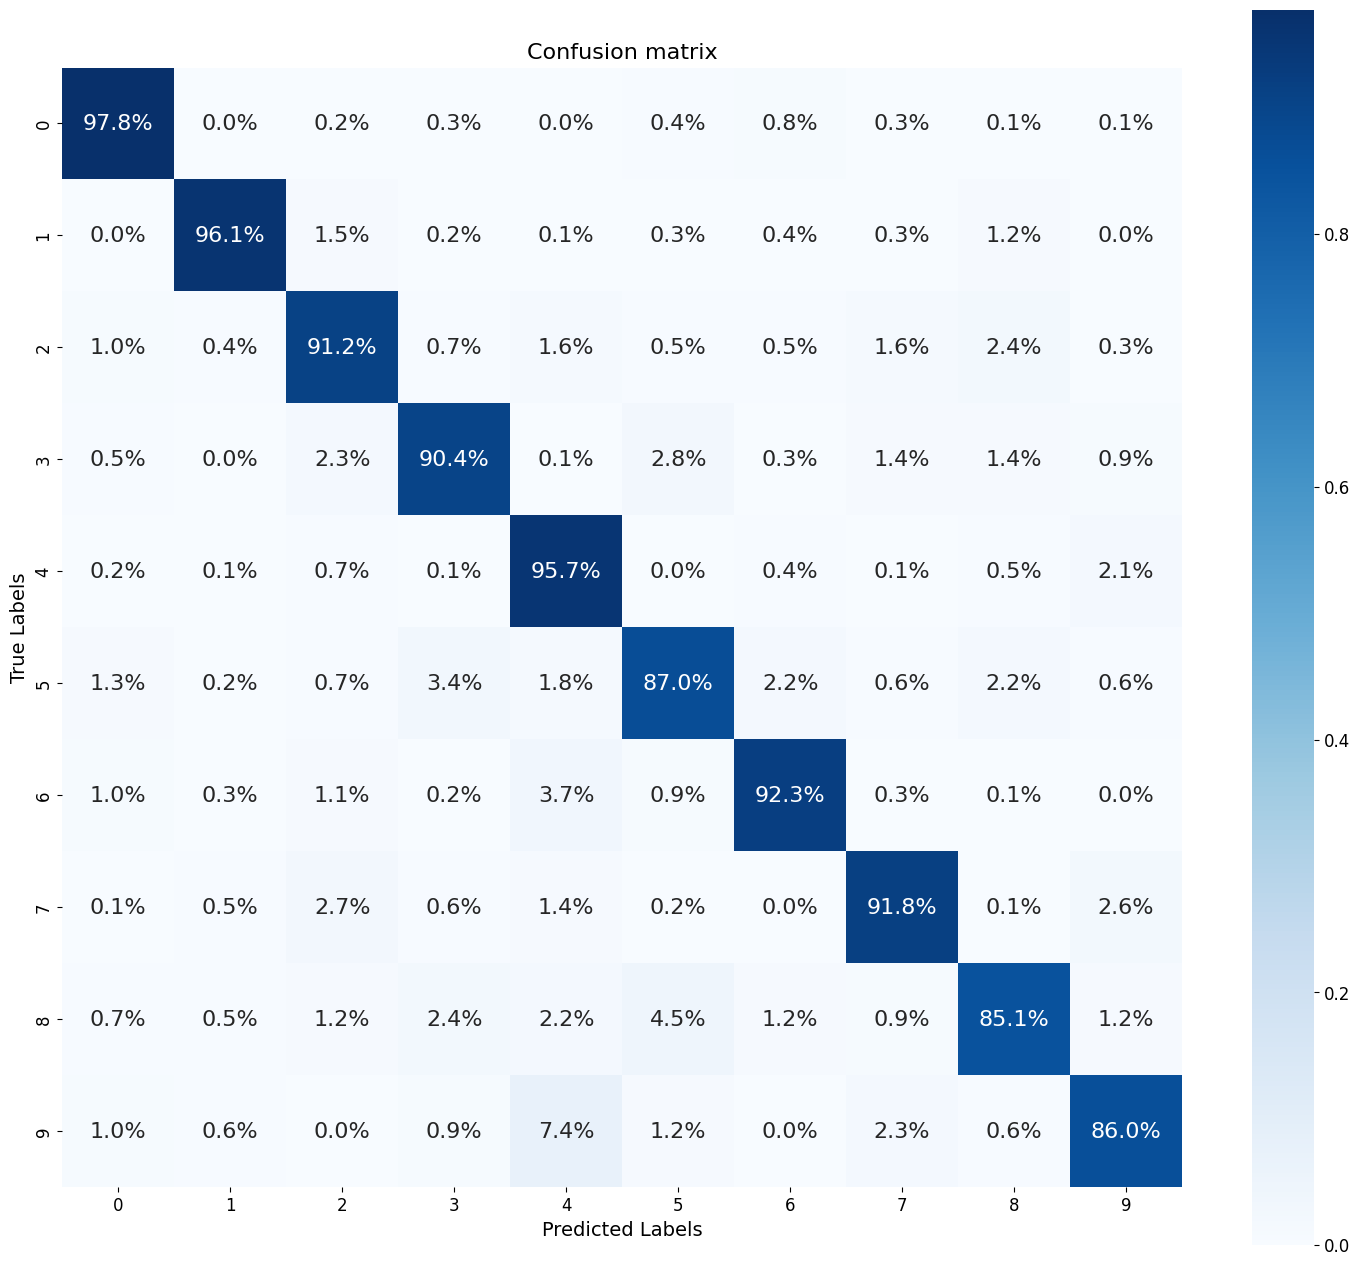

In [ ]:
plot_confusion_matrix(X_test, y_test, model, beta,
                      convert_to_percent=True, 
                      filename=filepath_location + "confusion") 

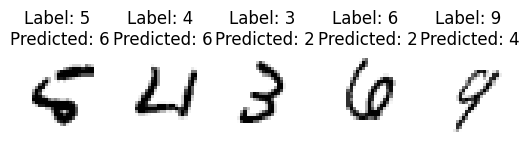

In [ ]:
plot_faulty_predictions(X_test, y_test, model, beta)